In [1]:
# ============================================
# fit2voi_wrapper.ipynb – dávkové volání skriptu fit2voi.py
# ============================================

# --- Buňka 1: Importy a příprava CSV ---
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

csv_file = "line_ratios_vs_temperature.csv"

# Pokud soubor existuje, smaž ho
if os.path.exists(csv_file):
    os.remove(csv_file)

# Vytvoř nový soubor s hlavičkou
header = "T_env;HITEMP_intensity_ratio;Amplitude_ratio;Total_area_ratio;Trimmed-area_ratio\n"
with open(csv_file, "w") as f:
    f.write(header)

In [2]:
# --- Buňka 2: Smyčka přes teploty a volání fit2voi.py ---
temps = list(range(1800, 2101, 30))

for T in temps:
    print(f"Spouštím fit2voi.py pro T = {T} K...")
    subprocess.run(["python", "fit2voi.py", "dummy", str(T)])


Spouštím fit2voi.py pro T = 1800 K...
Spouštím fit2voi.py pro T = 1830 K...
Spouštím fit2voi.py pro T = 1860 K...
Spouštím fit2voi.py pro T = 1890 K...
Spouštím fit2voi.py pro T = 1920 K...
Spouštím fit2voi.py pro T = 1950 K...
Spouštím fit2voi.py pro T = 1980 K...
Spouštím fit2voi.py pro T = 2010 K...
Spouštím fit2voi.py pro T = 2040 K...
Spouštím fit2voi.py pro T = 2070 K...
Spouštím fit2voi.py pro T = 2100 K...


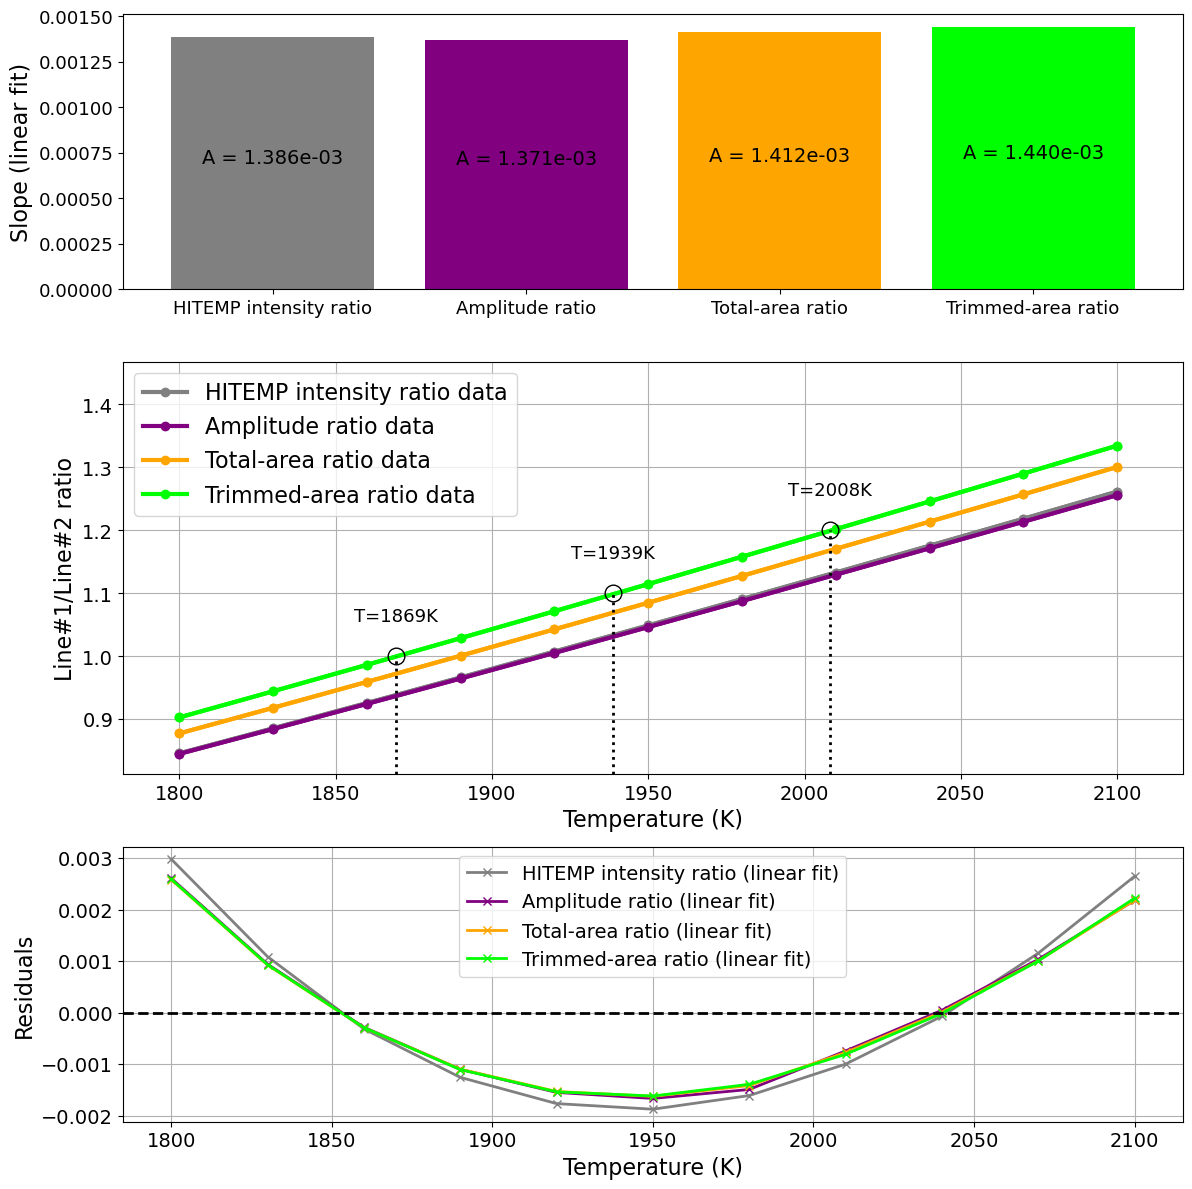

In [10]:
# --- Načtení CSV ---
data = np.loadtxt("line_ratios_vs_temperature.csv", delimiter=";", skiprows=1)
temps = data[:,0]
ratio_db, ratio_amp, ratio_total, ratio_trim = data[:,1], data[:,2], data[:,3], data[:,4]

ratios = {
    'HITEMP intensity ratio': ratio_db,
    'Amplitude ratio': ratio_amp,
    'Total-area ratio': ratio_total,
    'Trimmed-area ratio': ratio_trim,
}
colors = {
    'HITEMP intensity ratio': 'gray',
    'Amplitude ratio': 'purple',
    'Total-area ratio': 'orange',
    'Trimmed-area ratio': 'lime',
}

# --- Lineární fity ---
fits = {}
gradients = {}
residuals = {}

for key, y in ratios.items():
    A, B = np.polyfit(temps, y, 1)   # lineární fit Ax+B
    fits[key] = A*temps + B
    gradients[key] = A
    residuals[key] = y - fits[key]

# --- Figure se 3 panely ---
fig, (ax_top, ax_mid, ax_bot) = plt.subplots(3, 1, figsize=(12, 12),
                                             gridspec_kw={'height_ratios':[2,3,2]})

# --- Panel 1: Barplot gradientů ---
cats = list(ratios.keys())
vals = [gradients[c] for c in cats]
ax_top.bar(cats, vals, color=[colors[c] for c in cats])
ax_top.set_ylabel("Slope (linear fit)", fontsize=16)
ax_top.tick_params(axis='both', which='major', labelsize=13)
for i, v in enumerate(vals):
    ax_top.text(i, v/2, f"A = {v:.3e}", ha='center', fontsize=14)

# --- Panel 2: Data + lineární fit ---
for key in ratios:
    ax_mid.plot(temps, ratios[key], marker='o', color=colors[key], lw=3, label=key+" data")
#    ax_mid.plot(temps, fits[key], color=colors[key], lw=2, ls='dashed', label=key+" fit")

ax_mid.set_xlabel("Temperature (K)", fontsize=16)
ax_mid.set_ylabel("Line#1/Line#2 ratio", fontsize=16)
ax_mid.tick_params(axis='both', which='major', labelsize=14)
ax_mid.legend(loc='best', fontsize=16)
ax_mid.grid(True)

# --- Panel 2: Data + lineární fit ---
for key in ratios:
    ax_mid.plot(temps, ratios[key], marker='o', color=colors[key], lw=3, label=key+" data")

# Speciální zvýraznění pro Trimmed-area ratio (z lineárního fitu)
# Získání aktuální dolní hranice osy y
ymin_current = ax_mid.get_ylim()[0]

target_vals = [1.0, 1.1, 1.2]
for val in target_vals:
    T_target = (val - B) / A
    R_target = A*T_target + B
    
    # Prázdné kolečko na fitované křivce
    ax_mid.plot(T_target, R_target, marker='o', markersize=12,
                markeredgecolor='black', markerfacecolor='none', lw=0)
    
    # Svislá tečkovaná čára od kolečka dolů k dolní hranici grafu (např. 0.8)
    ax_mid.vlines(T_target, ymin=min(ratio_trim)*0.9, ymax=R_target,
                  color='black', ls='dotted', lw=2)
    
    # Popisek u bodu
    ax_mid.text(T_target, R_target+0.05,
                f"T={T_target:.0f}K",#\nR={R_target:.3f}",
                ha='center', va='bottom', fontsize=13, color='black')

# Nastavení rozsahu osy y, aby nezačínala od nuly
ax_mid.set_ylim(min(ratio_trim)*0.9, max(ratio_trim)*1.1)
ax_mid.set_xlim(min(temps)*0.99, max(temps)*1.01)

# --- Panel 3: Residuals ---
for key in ratios:
    ax_bot.plot(temps, residuals[key], marker='x', color=colors[key], lw=2, label=key+" (linear fit)")

ax_bot.axhline(0, color='black', ls='--', lw=2)
ax_bot.set_xlabel("Temperature (K)", fontsize=16)
ax_bot.set_ylabel("Residuals", fontsize=16)
ax_bot.tick_params(axis='both', which='major', labelsize=14)
ax_bot.legend(loc='best', fontsize=14)
ax_bot.grid(True)

# --- Formát os ---
sf = mticker.ScalarFormatter(useMathText=False)
sf.set_useOffset(False)
ax_mid.xaxis.set_major_formatter(sf)
ax_bot.xaxis.set_major_formatter(sf)

plt.tight_layout()
plt.show()

# Uložení do PDF
fig.savefig("line_ratios_vs_temperature.pdf", format="pdf", bbox_inches="tight")
